# **Paper Plots**
___

## Example Light Curves

In [18]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import snpy
import itertools
import pandas as pd

plt.rcParams["font.family"] = "GFS Artemisia"
plt.rcParams['mathtext.fontset'] = "cm"
%config InlineBackend.figure_format = 'retina'

DATA_DIR = 'csp_data'
OUT_DIR = 'paper_plots'
SNOOPY_MODEL = 'max_model'

In [19]:
# import matplotlib.font_manager
# from IPython.core.display import HTML

# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

'GFSArtemisia.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


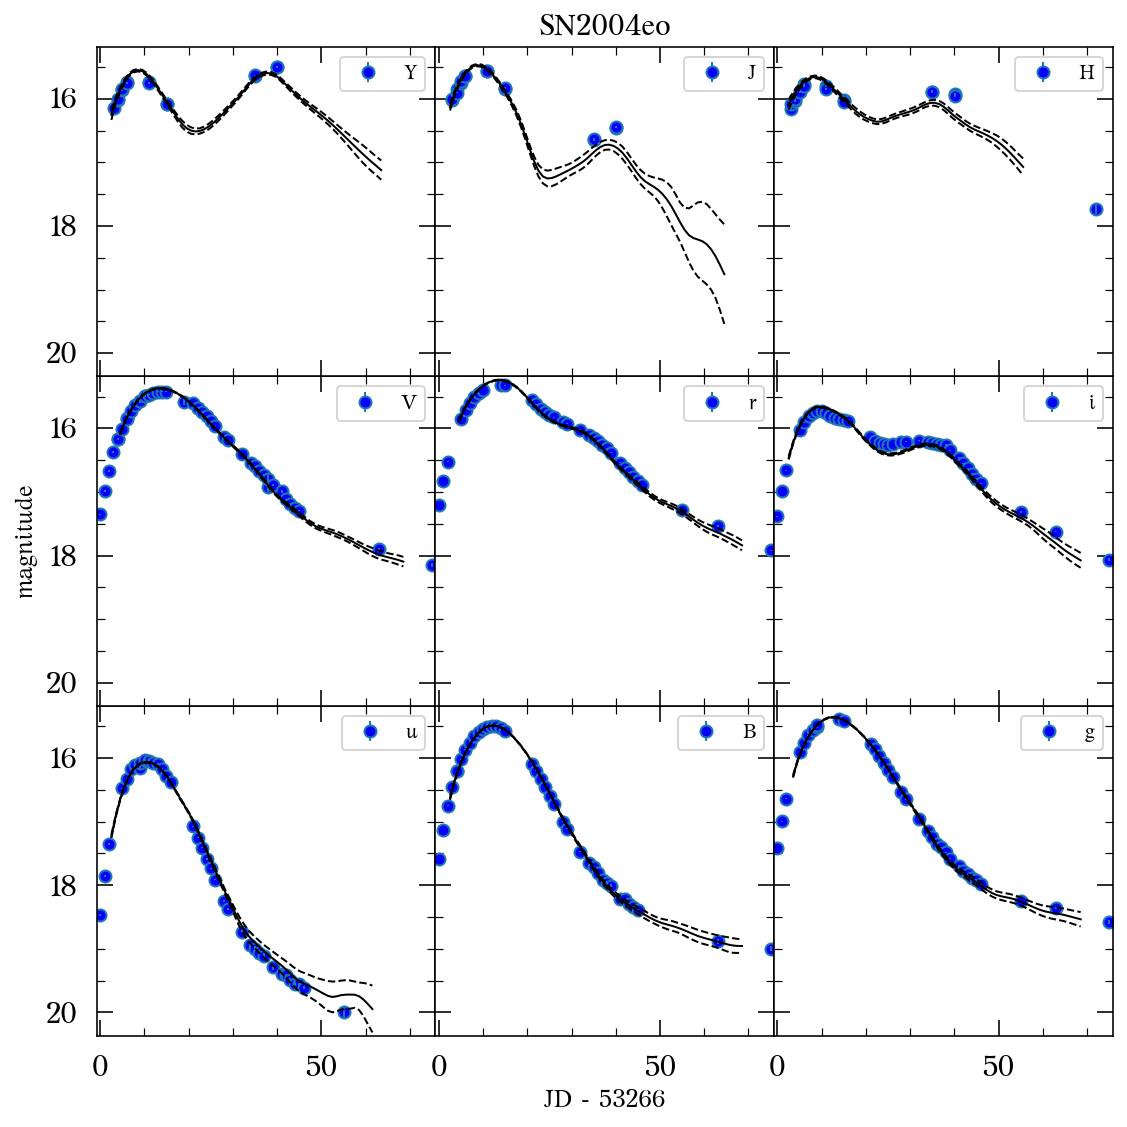

In [27]:
sn_name = 'SN2004eo'
sn_file = os.path.join(DATA_DIR, f'{sn_name}_snpy.txt')
sn = snpy.import_lc(sn_file)
sn.choose_model(SNOOPY_MODEL)
sn.data.pop('K')
sn.fit()
sn.plot(outfile='paper_plots/snoopy_fit.pdf')

In [3]:
def extract_data(sn_name):
    """Extracts the SN data into a dictionary.
    
    Parameters
    ==========
    sn_name: str
        Name of the SN to extract.
        
    Returns
    =======
    sn_dict: dict
        Dictionary with keys: `mjd`, `mag`, `err`.
    sn_info: list
        Extra info: `sn_name`, `z`, `ra`, `dec`.
    """
    
    sn_file = os.path.join(DATA_DIR, f'{sn_name}_snpy.txt')
    
    sn_dict = {}
    with open(sn_file, 'r') as data_file:
        sn_info = data_file.readline().split()  # header

        for line in data_file.readlines():
            if 'filter' in line:
                filt = line.split()[-1]
                sn_dict[filt] = {'mjd':[],
                                 'mag':[],
                                 'err':[],
                                }
            else:
                mjd, mag, err = line.split()
                sn_dict[filt]['mjd'].append(float(mjd))
                sn_dict[filt]['mag'].append(float(mag))
                sn_dict[filt]['err'].append(float(err))
                
    # turn lists into arrays
    for filt in sn_dict.keys():
        filt_dict = sn_dict[filt]
        for key in filt_dict.keys():
            sn_dict[filt][key] = np.array(sn_dict[filt][key])
            
    return sn_dict, sn_info

In [21]:
def plot_sn(sn_name, save=False):
    """Plots the SN data.
    
    Parameters
    ==========
    sn_name: str
        Name of the SN to extract.
    save: bool
        If `True`, the output plot is saved.
    """
    sn_dict, sn_info = extract_data(sn_name)
    
    # plotting arguments
    opt_filts = {'u':['s', 'purple', 1.0], 
                 'B':['o', 'blue', 0.6], 
                 'g':['d', 'darkgreen', 0.2], 
                 'V':['p', 'limegreen', -0.2], 
                 'r':['v', 'red', -0.6], 
                 'i':['h', 'orange', -1.4]}
    NIR_filts = {'Y':['s', 'yellow', -0.5], 
                 'J':['o', 'darkorange', 0.0], 
                 'H':['d', 'olive', 0.5], 
                 #'K':['p', 'firebrick', 1.0]
                }

    filts = opt_filts.copy()
    filts.update(NIR_filts)

    fig, axes = plt.subplots(1, 2, figsize=(10, 6), 
                                     sharey=True, gridspec_kw={'wspace':0})

    for filt, plot_args in filts.items():
        if filt in sn_dict.keys():
            filt_data = sn_dict[filt]
            mjd, mag, err = filt_data['mjd'], filt_data['mag'], filt_data['err']

            # split between opt and NIR
            if filt in opt_filts.keys():
                ax = axes[0]
            else:
                ax = axes[1]

            marker, color, offset = plot_args
            if offset<0.0:
                label =  f'${filt}-{str(offset)[1:]}$'
            else:
                label = f'${filt}+{str(offset)}$'
            ax.errorbar(mjd, mag+offset, yerr=err, label=label,
                       ms=10, fmt=marker+'--', color=color, mec='k')

    for ax in axes:
        ax.set_xlabel('Modified Julian Date', fontsize=20)
        ax.tick_params(labelsize=20)
        ax.legend(fontsize=14, ncol=1)

    axes[0].set_ylabel('Apparent Magnitude', fontsize=20)
    ax.invert_yaxis()
    fig.suptitle(sn_name, fontsize=22)
    if save:
        plt.tight_layout()
        output = os.path.join(OUT_DIR, sn_name+'.pdf')
        plt.savefig(output)
    plt.show()

'GFSArtemisia.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


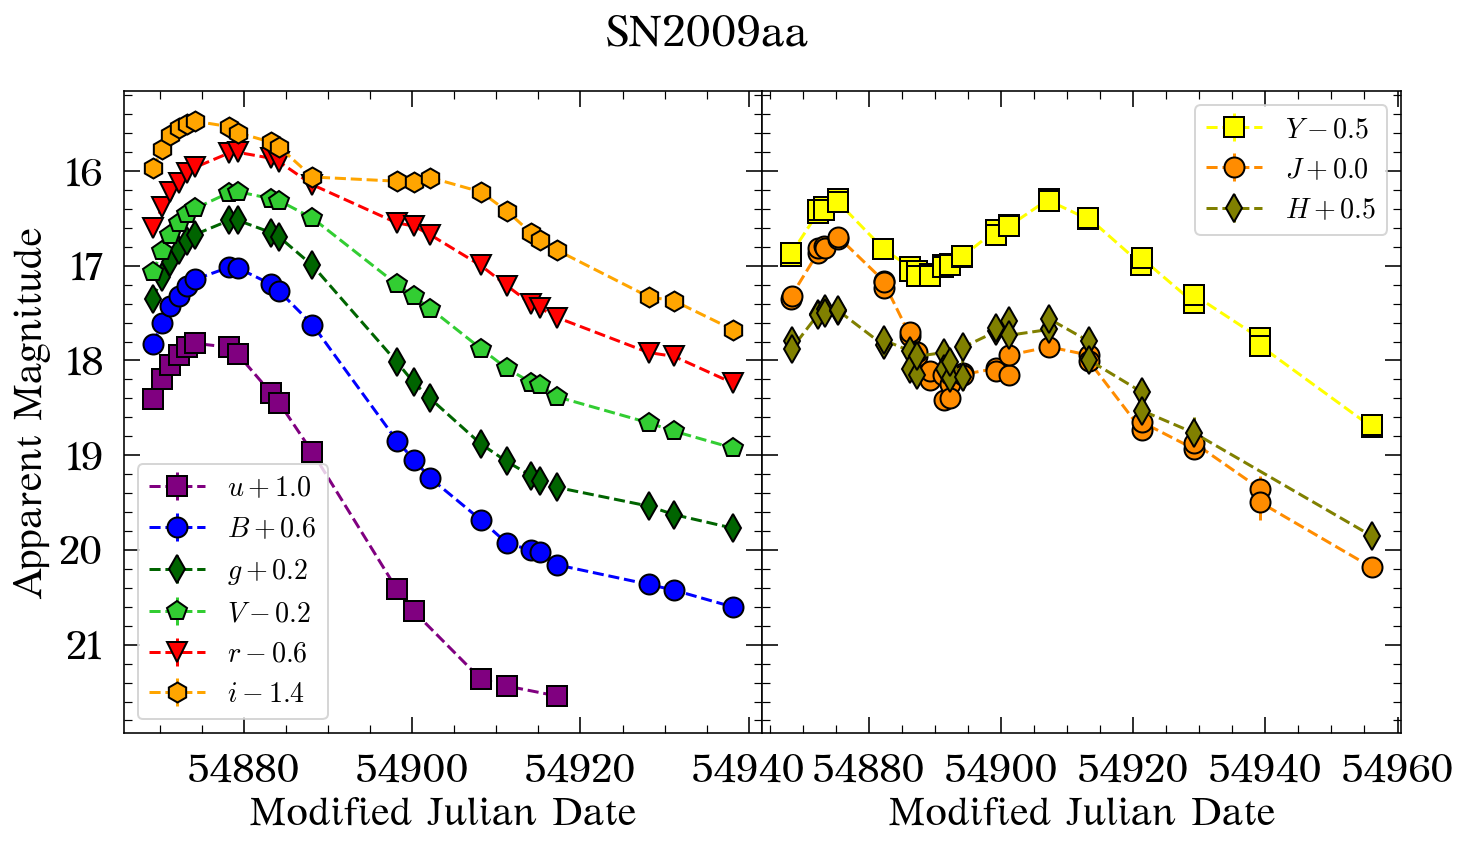

In [25]:
sn_name = 'SN2009aa'  # SN2004eo, SN2005M, SN2009aa, LSQ12bld, PTF13ebh, ASAS14lp
plot_sn(sn_name, True)

___
## Simulations Plots

In [5]:
def combinations(iterable, r):
    '''Returns all possible combinations without permutation.
    
    **Note:** the output should be inserted in a list
    
    Parameters
    ==========
    iterable: list-like
        List of items from which the combination is computed.
    r: int
        Numbers of items for the combination.
        
    Returns
    =======
    comb_list: list
        List with all combinations.
    '''
    
    comb_list = list(itertools.combinations(iterable, r))
    
    return comb_list            
            
def mag2flux(mag, zp, mag_err=0.0):
    """Converts magnitudes to fluxes, propagating errors if given.
    
    Parameters
    ----------
    mag : array
        Array of magnitudes.
    zp : float or array
        Zero points.
    mag_err : array, default ``0.0``
        Array of magnitude errors.
        
    Returns
    -------
    flux : array
        Magnitudes converted to fluxes.
    flux_err : array
        Magnitude errors converted to errors in fluxes.
    """

    flux = 10**( -0.4*(mag-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*mag_err )

    return flux, flux_err

def update_sn(sn, update_dict):
    """Updates the data of a SN (mjd, flux, mag, etc.).
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    update_dict: dict
        Dictionary with new SN data with bands as keys and sub-dictionaries
        as values. Each sub-dictionary must have `mjd`, `mag` and `mag_err` 
        as keys and their respective values.
        
    Returns
    =======
    sn: SNooPy object
        Updated SN.
    """
    
    for band, data_dict in update_dict.items():

        mjd = data_dict['mjd']
        mag, mag_err = data_dict['mag'], data_dict['mag_err']
        
        sn.data[band].MJD = mjd
        sn.data[band].magnitude = mag
        sn.data[band].mag = mag
        sn.data[band].e_mag = mag_err

        zp = sn.data[band].filter.zp
        flux, flux_err = mag2flux(mag, zp, mag_err)

        # there are some hidden parameters like "_flux" and "_eflux"
        # which are used by other internal functions
        sn.data[band].flux = flux
        sn.data[band]._flux = flux
        sn.data[band].e_flux = flux_err
        sn.data[band]._eflux = flux_err

        # not sure if these are completely necessary, but just in case...
        sn.data[band].sids = np.zeros_like(flux)
        sn.data[band].__dict__['mask'] = np.array([True]*len(flux))
        
    return sn

def filter_coeval_NIRdata(sn):
    """Filters out NIR data of a SNooPy object that are not
    coeval in J and H bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    The updated sn.
    """
    
    # NIR bands labels
    NIR_bands = [band for band in sn.allbands() if band in ['J', 'H']]
    NIR_ebands = [f'e_{band}' for band in NIR_bands]  # for errors

    # Find epochs with coeval J and H bands
    sn_df = pd.DataFrame(sn.get_mag_table())
    sn_df.replace(99.900000, np.nan, inplace=True)

    sn_df = sn_df[['MJD'] + NIR_bands + NIR_ebands].dropna()

    # update SN J and H bands data
    NIR_dict = {band:None for band in NIR_bands}
    for band, eband in zip(NIR_bands, NIR_ebands):
        indeces = sn_df[band].dropna().index
        mjd = sn_df['MJD'].loc[indeces].values
        mag = sn_df[band].loc[indeces].values
        mag_err = sn_df[eband].loc[indeces].values
        NIR_dict[band] = {'mjd':mjd, 'mag':mag, 'mag_err':mag_err}

    sn = update_sn(sn, NIR_dict)
    
    return sn

def extract_combinatories(values, n_epochs):
    """Extracts a list of all the combinatories of `values` with 
    `n_epochs` number of items each.
    
    Parameters
    ==========
    values: list-like
        List of values from which the combinatories are extracted.
    n_epochs: int
        Number of items per combinatory.
        
    Returns
    =======
    list_alt_values: list
        List of all the combinatories, where each combinatory is a numpy array.
    """
    
    comb_values_tuples = combinations(values, n_epochs)
    list_comb_values = [np.array(tup) for tup in comb_values_tuples]

    return list_comb_values

def extract_combinatories_dict(sn, n_epochs):
    """Extracts a dictionary with all the combinatories of `mjd`, `mag` and `mag_err`
    for a SN in J and H bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of items per combinatory.
        
    Returns
    =======
    NIR_dict: dict
        Dictionary with the NIR bands as keys and sub-dictionaries as values.
        Each sub-dictionary has `mjd`, `mag` and `mag_err` as keys and a list
        of combinatories (the results of `alternate_values()`) as values.
    """
    
    # NIR bands labels
    NIR_bands = [band for band in sn.allbands() if band in ['J', 'H']]
    NIR_dict = {band:None for band in NIR_bands}
    
    for band in NIR_bands:      
        mjd = sn.data[band].MJD.copy()
        mag = sn.data[band].magnitude.copy()
        mag_err = sn.data[band].e_mag.copy()
        bands = [band]*len(sn.data[band].MJD)
        
        mjd_list = extract_combinatories(mjd, n_epochs)
        mag_list = extract_combinatories(mag, n_epochs)
        mag_err_list = extract_combinatories(mag_err, n_epochs)
        band_list = extract_combinatories(bands, n_epochs)
        
        NIR_dict[band] = {'mjd':mjd_list, 
                          'mag':mag_list, 
                          'mag_err':mag_err_list,
                          'band':band_list}
            
    return NIR_dict

def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    **Note:** NaN is returned if the parameter is not
    found.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    if parameter in sn.parameters.keys():
        value = sn.parameters[parameter]
        stats_err = sn.errors[parameter]
        if include_sys:
            sys_err = sn.systematics()[parameter]
        else:
            sys_err = 0.0
        err = np.sqrt(stats_err**2 + sys_err**2)
    else:
        value = err = np.nan
    
    return value, err

def extract_lc_params(sn):
    """Extracts the estimated light-curve parameters.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    lc_dict: dict
        Dictionary with the light-curve parameter names as keys
        and parameter values as values.
    """

    parameters = ['Tmax', 'st', 'gmax', 'rmax', 'Jmax', 'Hmax']
    lc_dict = {}
    
    for parameter in parameters:
        value, value_err = get_parameter(sn, parameter)
        lc_dict[parameter] = value
        lc_dict[parameter+'_err'] = value_err
        
    return lc_dict
    
def fit_combinatory(sn, n_epochs):
    """Fits a SN multiple times for all the combinatories given by `n_epochs`.
    The fits are performed with grJ, grH and grJH bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of items per combinatory.
    """
    
    assert n_epochs<=3, 'Combinatories are only calculated for `n_epochs` <= 3'

    # output parameters
    parameters = ['comb', 'm1', 'm2', 'm3', 
                  'Tmax', 'Tmax_err', 'st', 'st_err',
                  'gmax', 'gmax_err', 'rmax', 'rmax_err',
                  'Jmax', 'Jmax_err', 'Hmax', 'Hmax_err']
    out_dict = {'J':[],
                'H':[]}
    suffixes = [#'J', 
                #'H', 
                'JH'
               ] 
    
    all_results_dict = {suffix:{param:[] for param in parameters}
                                                for suffix in suffixes}
    # set of bands to fit
    set_bands2fit = [#['g', 'r', 'J'],  # NIR J only
                     #['g', 'r', 'H'],  # NIR H only
                     ['g', 'r', 'J', 'H']]  # NIR J and H
    
    # outputs directories
    if not os.path.isdir('sim_fits'):
        os.mkdir('sim_fits')
        
    sn_dir = os.path.join('sim_fits', sn.name)
    if not os.path.isdir(sn_dir):
        os.mkdir(sn_dir)
    
    sn = filter_coeval_NIRdata(sn)
    # extract dictionary with all the combinatory for the NIR bands
    comb_dict = extract_combinatories_dict(sn, n_epochs)
    
    NIR_bands = list(comb_dict.keys())
    num_comb = len(comb_dict['H']['mjd'])  # number of combinations
    
    # update SN with each combinatory
    for i in range(num_comb):  
        NIR_dict = {band:{'mjd':[], 'mag':[], 'mag_err':[]} 
                                        for band in NIR_bands}
        
        # Jrc2 is already combined with J at this stage (if there is J and 
        # Jrc2), but splitted below
        for band, band_info in comb_dict.items(): 
            if band_info is not None:
                mjd = band_info['mjd'][i]
                mag = band_info['mag'][i]
                mag_err = band_info['mag_err'][i]
                bands = band_info['band'][i]

                # this sub_bands parts is due to having two J bands,
                # i.e., J and Jrc2, which makes things complicated.
                # Here J and Jrc2 are splitted again as they were combined.
                for j, sub_band in enumerate(bands):
                    NIR_dict[sub_band]['mjd'].append(mjd[j])
                    NIR_dict[sub_band]['mag'].append(mag[j])
                    NIR_dict[sub_band]['mag_err'].append(mag_err[j])
            
        # turn lists into arrays for SNooPy
        for band in NIR_bands:
            for key in NIR_dict[band].keys():
                NIR_dict[band][key] = np.array(NIR_dict[band][key])
            
        sn = update_sn(sn, NIR_dict)
        
        # As there is J and Jrc2 bands, sometimes one of them can be empty
        # and needs to be removed, but then added again below
        empty_lc = None
        for band in sn.allbands():
            if len(sn.data[band].MJD)==0:
                empty_lc = sn.data.pop(band)
                popped_band = band
                
        sn.filter_order = None  # this is necessary as we remove bands

        try:            
            for bands, suffix in zip(set_bands2fit, suffixes):
                bands2fit = [band for band in sn.allbands() 
                                     if band in bands]
                sn.choose_model(SNOOPY_MODEL)
                sn.fit(bands2fit)

                # light-curve parameters
                lc_dict = extract_lc_params(sn)
                for key, value in lc_dict.items():
                    all_results_dict[suffix][key].append(value)

            # get the empty light curve back
            if empty_lc is not None:
                sn.data[popped_band] = empty_lc
            
        except Exception as message:
            print(f'Combinatory number {i} failed for {sn.name}: {message}!')
            if empty_lc is not None:
                sn.data[popped_band] = empty_lc
         
        # save output
        for band in ['J', 'H']:
            mjd = sn.data[band].MJD
            mag = sn.data[band].mag

            model_time = np.arange(sn.Tmax-10, sn.Tmax+50)
            model_mag, _ = sn.data[band].eval(model_time)
            
            band_dict = {'mjd':mjd, 'mag':mag,
                         'model_time':model_time, 
                         'model_mag':model_mag}
            out_dict[band].append(band_dict)
            
    return out_dict

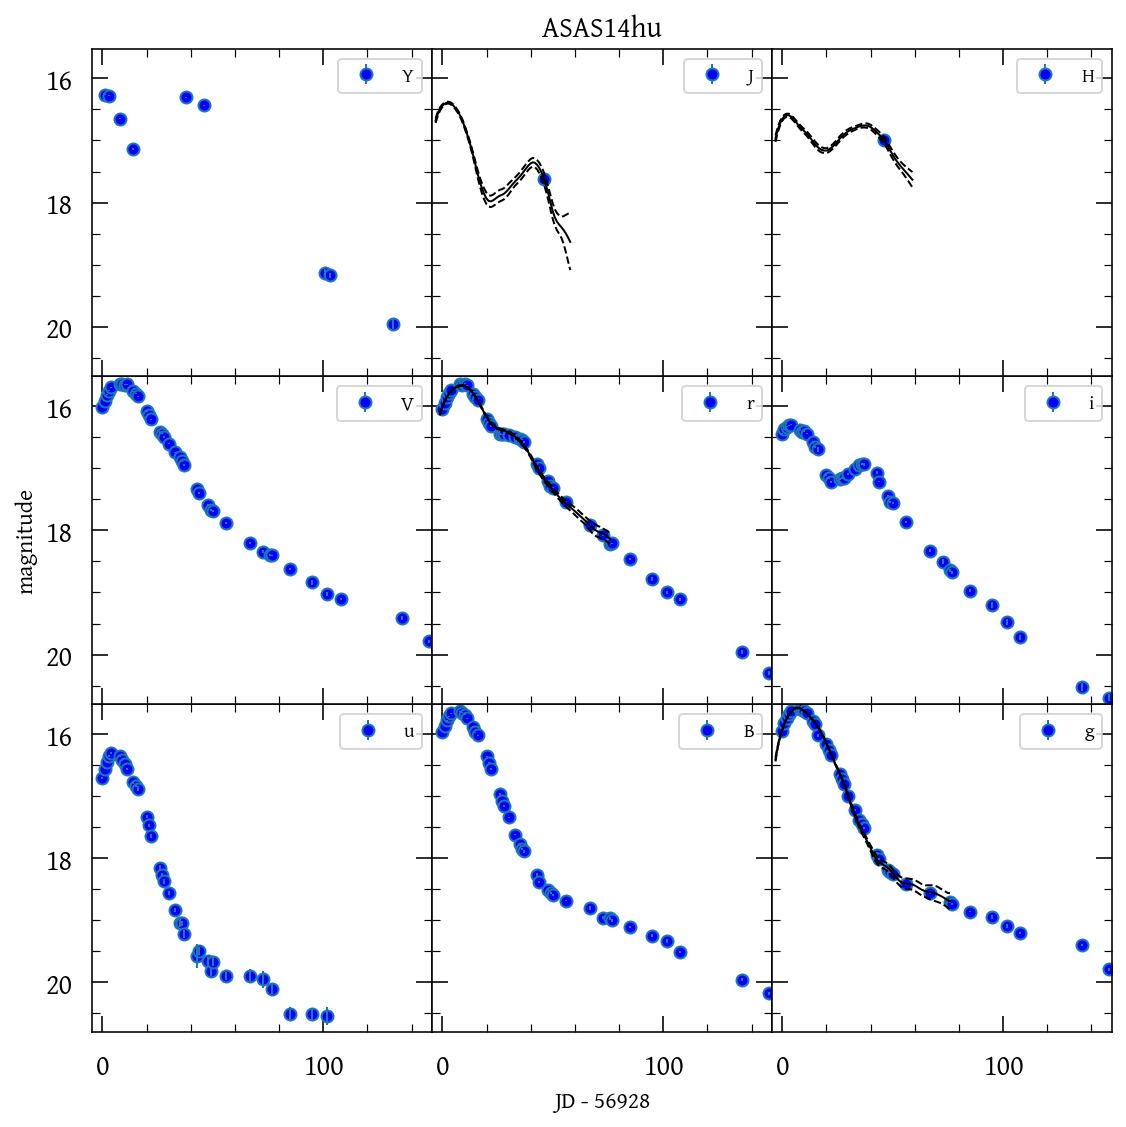

In [13]:
sn_name = 'ASAS14hu'
sn_file = os.path.join(DATA_DIR, f'{sn_name}_snpy.txt')
sn = snpy.import_lc(sn_file)
model_dict = fit_combinatory(sn, 1)

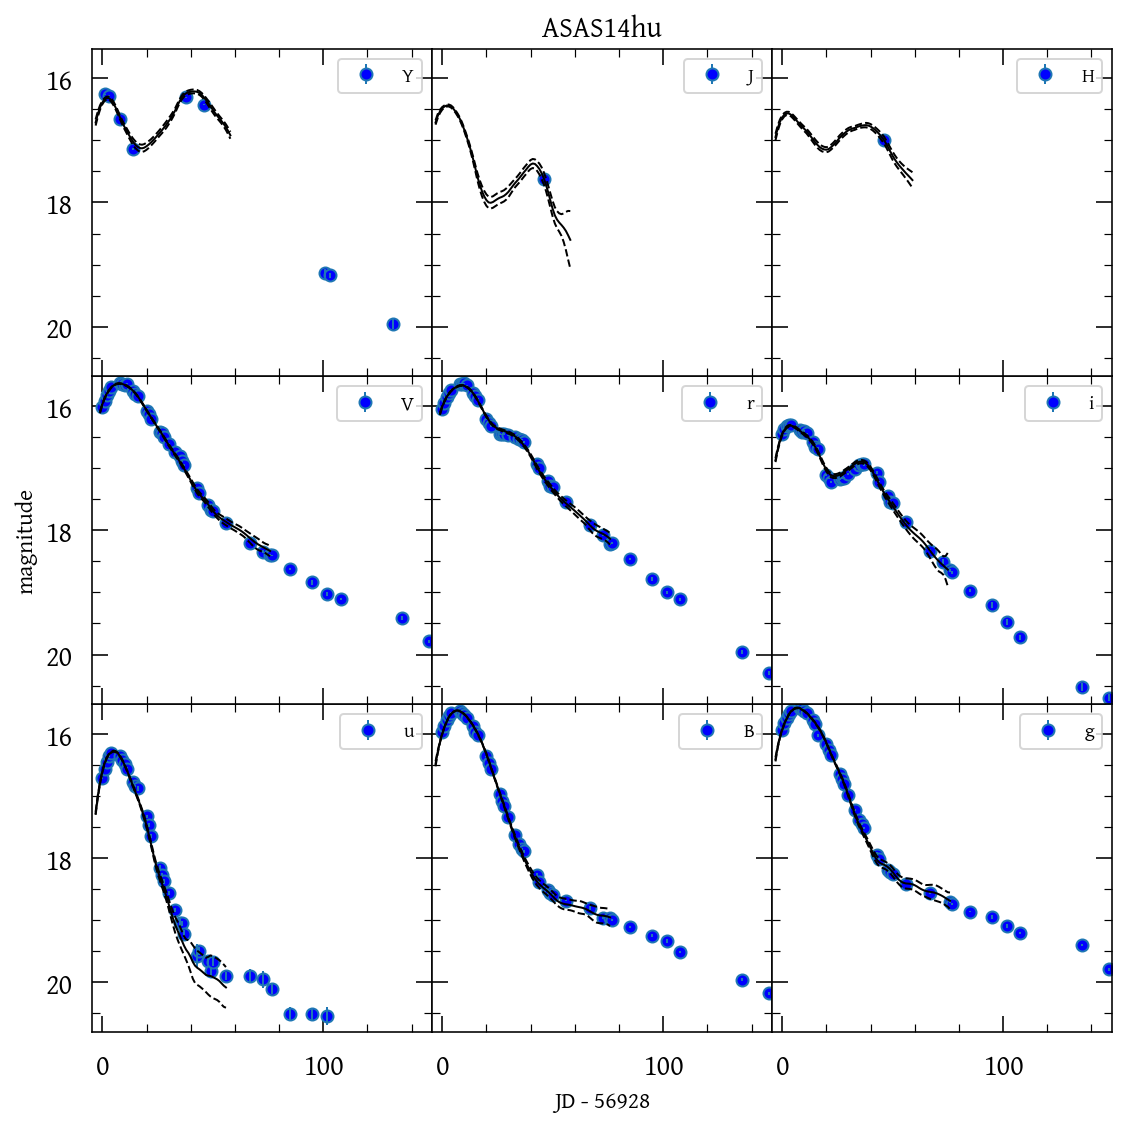

In [9]:
sn.fit()

'GFSArtemisia.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


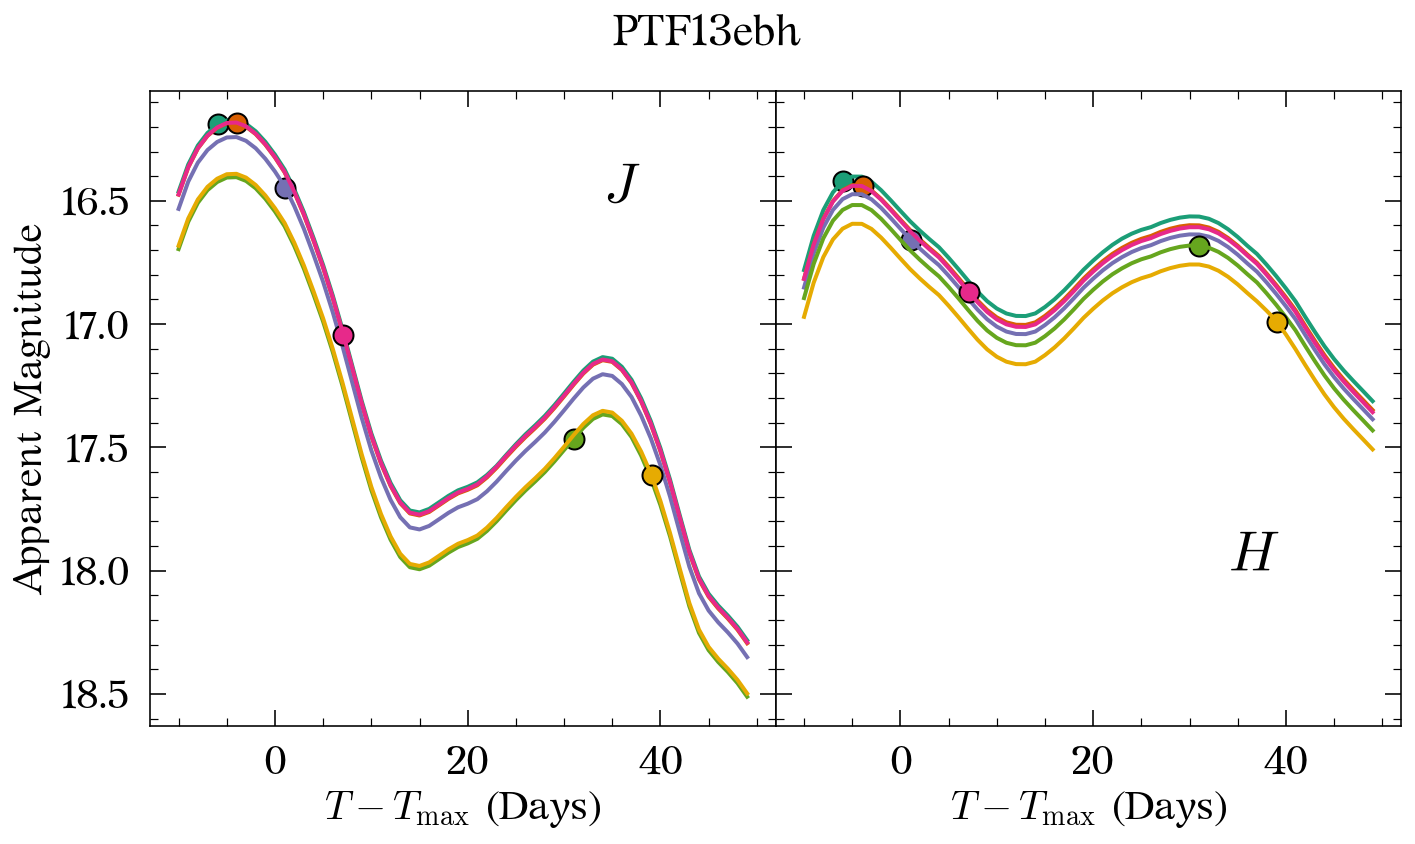

In [66]:
colors = plt.get_cmap('Dark2').colors
#colors = [plt.get_cmap('Dark2').colors[::-1] + plt.get_cmap('Set1').colors][0][::3]

fig, axes = plt.subplots(1, 2, figsize=(10, 6), 
                         sharey=True, gridspec_kw={'wspace':0})

for ax, band_list in zip(axes, model_dict.values()):
    for i, band_dict in enumerate(band_list):
        mjd, mag = band_dict['mjd'], band_dict['mag']
        model_time = band_dict['model_time']
        model_mag = band_dict['model_mag']
        
        ax.plot(mjd-sn.Tmax, mag, 'o', ms=10, mec='k', color=colors[i])
        ax.plot(model_time-sn.Tmax, model_mag, lw=2, color=colors[i])
        
    #ax.set_xlabel('Modified Julian Date', fontsize=20)
    ax.set_xlabel(r'$T - T_{\rm max}$ (Days)', fontsize=20)
    ax.tick_params(labelsize=20)
    
axes[0].set_ylabel('Apparent Magnitude', fontsize=20)
ax.invert_yaxis()
fig.suptitle(sn_name, fontsize=22)

axes[0].text((model_time-sn.Tmax).max()-15, 16.5, '$J$', fontsize=28)
axes[1].text((model_time-sn.Tmax).max()-15, 18, '$H$', fontsize=28)

plt.tight_layout()
output = os.path.join(OUT_DIR, 'sim_example.pdf')
plt.savefig(output)
    
plt.show()

## Redshift Distribution

In [67]:
def extract_data(sn_name):
    """Extracts the SN data into a dictionary.
    
    Parameters
    ==========
    sn_name: str
        Name of the SN to extract.
        
    Returns
    =======
    sn_dict: dict
        Dictionary with keys: `mjd`, `mag`, `err`.
    sn_info: list
        Extra info: `sn_name`, `z`, `ra`, `dec`.
    """
    
    sn_file = os.path.join(DATA_DIR, f'{sn_name}_snpy.txt')
    
    sn_dict = {}
    with open(sn_file, 'r') as data_file:
        sn_info = data_file.readline().split()  # header
        z = float(sn_info[1])
        sn_dict[sn_name] = z
                
    # turn lists into arrays
    for filt in sn_dict.keys():
        filt_dict = sn_dict[filt]
        for key in filt_dict.keys():
            sn_dict[filt][key] = np.array(sn_dict[filt][key])
            
    return sn_dict, sn_info

'GFSArtemisia.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


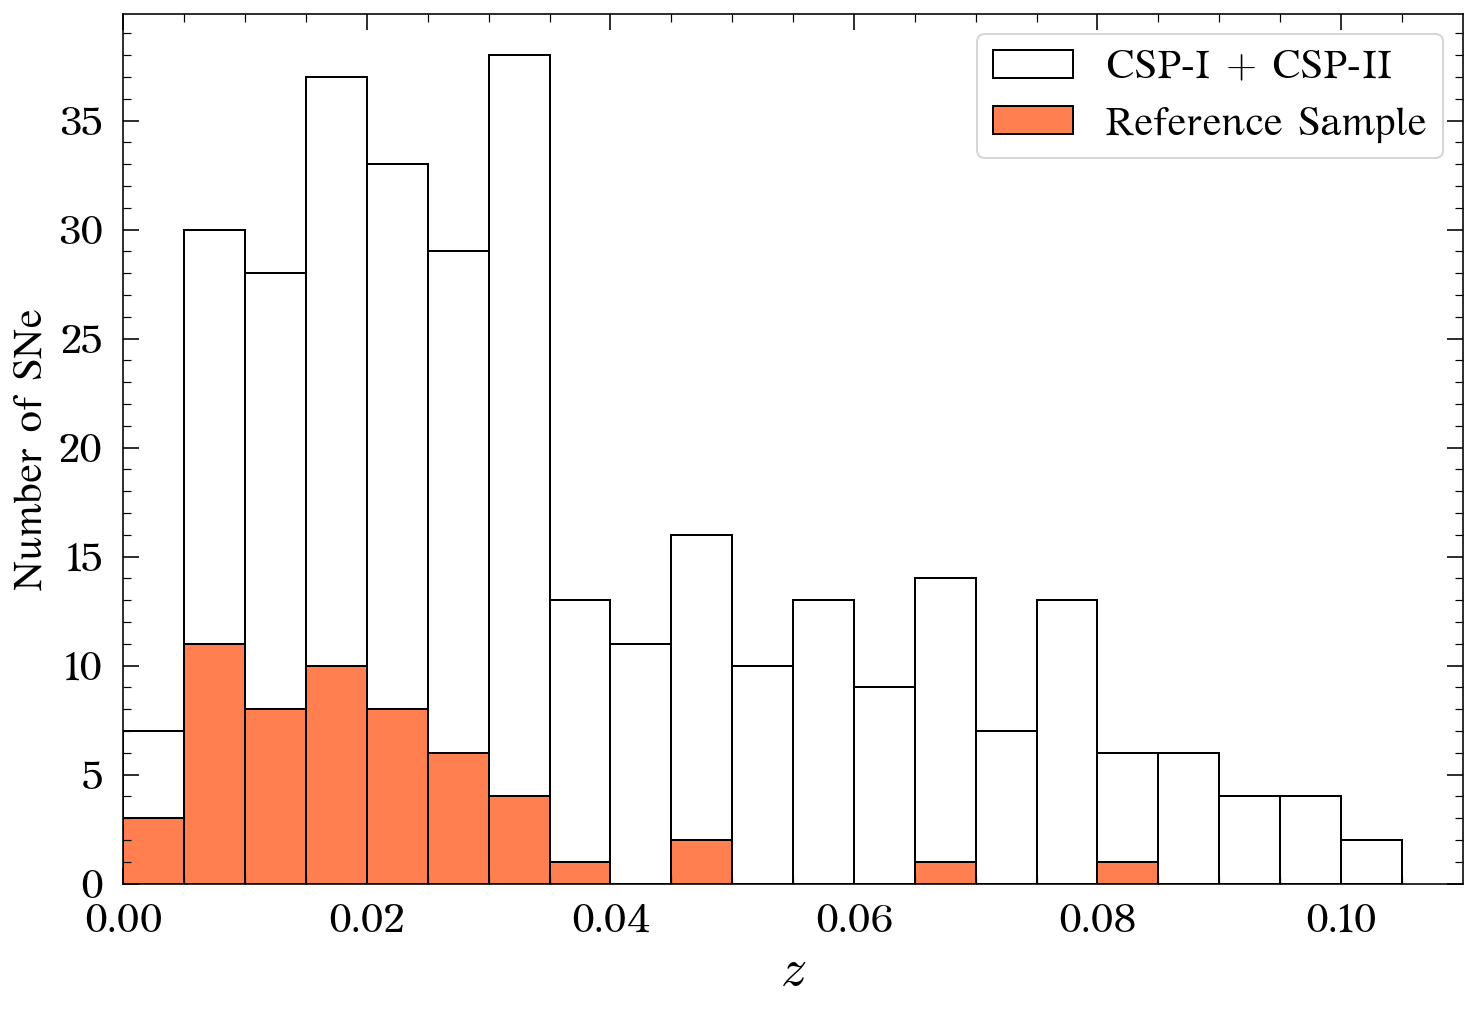

In [68]:
# ref sample
sn_files = np.loadtxt('reference_files.txt', dtype=str).T

z_list = []
for sn_file in sn_files:
     with open(sn_file, 'r') as data_file:
            sn_info = data_file.readline().split()  # header
            z = float(sn_info[1])
            z_list.append(z)
    
# all SNe    
zall_list = []
for sn_file in glob.glob('csp_data/*'):
     with open(sn_file, 'r') as data_file:
            sn_info = data_file.readline().split()  # header
            z = float(sn_info[1])
            zall_list.append(z)
            
# plot
fig, ax = plt.subplots(figsize=(12, 8))

bins = np.arange(0, 0.11, 0.005)
ax.hist(zall_list, bins, edgecolor='k', fc=(0, 0, 0, 0.0), label='CSP-I $+$ CSP-II')
ax.hist(z_list, bins, edgecolor='k', color='coral', label='Reference Sample')

ax.tick_params(labelsize=20)
ax.set_xlabel('$z$', fontsize=26)
ax.set_ylabel(f'Number of SNe', fontsize=20)
ax.set_xlim(0, 0.11)
ax.legend(fontsize=20)

plt.savefig(f'paper_plots/z_dist.pdf', bbox_inches='tight')
plt.show()